In [1]:
import numpy as np
import pandas as pd
import re
import h5py
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, auc, roc_curve
from keras.layers.core import Masking
from keras.layers import Dense, LSTM, Dropout, Embedding
#from keras.layers.wrappers import Bidirectional
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Embedding, TimeDistributed
from keras.models import load_model
from tensorflow.python.client import device_lib
from lxml import etree
from itertools import groupby
from gensim.models import Word2Vec
import glob
import math
import itertools
from sklearn.metrics import *
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
tree = ET.parse('data\labeled_flows_xml\TestbedMonJun14Flows.xml')  
root = tree.getroot()

In [3]:
appName =[]
totalSourceBytes=[]
totalDestinationBytes=[]
totalDestinationPackets=[]
totalSourcePackets=[]
sourcePayloadAsBase64=[]
destinationPayloadAsBase64=[]
destinationPayloadAsUTF=[]
direction=[]
sourceTCPFlagsDescription=[]
destinationTCPFlagsDescription=[]
source=[]
protocolName=[]
sourcePort=[]
destination=[]
destinationPort=[]
startDateTime=[]
stopDateTime=[]
Tag=[]

In [4]:
for em in root.iter('appName'):
    appName.append(em.text)
for bt in root.iter('totalSourceBytes'):
    totalSourceBytes.append(bt.text)
for db in root.iter('totalDestinationBytes'):
    totalDestinationBytes.append(db.text)
for dp in root.iter('totalDestinationPackets'):
    totalDestinationPackets.append(dp.text)
for sp in root.iter('totalSourcePackets'):
    totalSourcePackets.append(sp.text)
for paybase in root.iter('sourcePayloadAsBase64'):
    sourcePayloadAsBase64.append(paybase.text)
for destpay in root.iter('destinationPayloadAsBase64'):
    destinationPayloadAsBase64.append(destpay.text)
for dr in root.iter('direction'):
    direction.append(dr.text)
for tcpf in root.iter('sourceTCPFlagsDescription'):
    sourceTCPFlagsDescription.append(tcpf.text)
for dtcpf in root.iter('destinationTCPFlagsDescription'):
    destinationTCPFlagsDescription.append(dtcpf.text)
for src in root.iter('source'):
    source.append(src.text)
for pname in root.iter('protocolName'):
    protocolName.append(pname.text)
for sport in root.iter('sourcePort'):
    sourcePort.append(sport.text)
for destntn in root.iter('destination'):
    destination.append(destntn.text)
for destntnp in root.iter('destinationPort'):
    destinationPort.append(destntnp.text)
for datet in root.iter('startDateTime'):
    startDateTime.append(datet.text)
for stopt in root.iter('stopDateTime'):
    stopDateTime.append(stopt.text)
for tag in root.iter('Tag'):
    Tag.append(tag.text)        

In [5]:
df = pd.DataFrame({'appName': appName,'totalSourceBytes':totalSourceBytes,'totalDestinationBytes':totalDestinationBytes,
                   'totalDestinationPackets':totalDestinationPackets,'totalSourcePackets':totalSourcePackets,
                   'sourcePayloadAsBase64': sourcePayloadAsBase64, 'destinationPayloadAsBase64': destinationPayloadAsBase64,
                  'direction':direction, 'sourceTCPFlagsDescription': sourceTCPFlagsDescription, 
                   'destinationTCPFlagsDescription':destinationTCPFlagsDescription,  'source': source, 'protocolName':protocolName,
                  'sourcePort':sourcePort, 'destination': destination,'destinationPort':destinationPort,
                  'startDateTime':startDateTime, 'stopDateTime':stopDateTime, 'tag':Tag})
df = df.drop_duplicates()

In [6]:
## Produce undirected IP-dyads and order by time
df = df.sort_values('startDateTime')
df['seqId'] = df['source'] + '_' + df['destination'] + '_' + df['startDateTime'].str[:13]
df['lowPort'] = np.where(df.destinationPort <= df.sourcePort, df['destinationPort'], df['sourcePort'])

In [7]:
## Build hour-IP-dyad keys and sequences
key = df.groupby('seqId')[['tag','lowPort']].agg({"tag":lambda x: "%s" % ','.join([a for a in x]),"lowPort":lambda x: "%s" % ','.join([str(a) if int(a)<10000 else "10000" for a in x])})
print("Unique Keys: "+str(key.count()))
attacks = [a.split(",") for a in key.tag.tolist()]
sequences = [a.split(",") for a in key.lowPort.tolist()]

Unique Keys: tag        22658
lowPort    22658
dtype: int64


In [8]:
# Create Label Encoder and add one to account for 0. masking
##
print("Generating Label Encoder...")
unique_tokens = list(set([a for b in sequences for a in b]))
le = LabelEncoder()
le.fit(unique_tokens)
sequences = [le.transform(s).tolist() for s in sequences]
sequences = [[b+1 for b in a] for a in sequences]

sequence_attack = zip(attacks, sequences)


Generating Label Encoder...


In [9]:
## Build sequences
##
print("Generating sequences for model...")
na_value = 0.
seq_len = 10

seq_index = []
seq_x = []
seq_y = []
seq_attack = []
for si, (sa, ss) in enumerate(sequence_attack):
    prepend = [0.] * (seq_len)
    seq =  prepend + ss
    seqa = prepend + sa
    for ii in range(seq_len, len(seq)):
        subseq = seq[(ii-seq_len):(ii)]
        vex = []
        for ee in subseq:
            try:
                vex.append(ee)
            except:
                vex.append(na_value)
        seq_x.append(vex)
        seq_y.append(seq[ii])
        seq_index.append(si)
        seq_attack.append(seqa[ii])

Generating sequences for model...


In [10]:
## Make One-hot-encoder
##
print("Initializing One-hot-encoder...")
ohe = OneHotEncoder(sparse=False, categories='auto')
ohe.fit(np.unique(seq_y).reshape(-1,1))
X = np.array(seq_x)

Initializing One-hot-encoder...


c:\Users\crisb\miniconda3\envs\Ai\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
# Generator for Batch Training
##
class BatchGenerator(object):
    def __init__(self, batch_size, x, y, ohe):
        self.batch_size = batch_size
        self.n_batches = int(math.floor(np.shape(x)[0] / batch_size))
        self.batch_index = [a * batch_size for a in range(0, self.n_batches)]
        self.x = x
        self.y = y
        self.ohe = ohe
        
    def __iter__(self):
        for bb in itertools.cycle(self.batch_index):
            y = self.y[bb:(bb+self.batch_size)]
            ohe_y = self.ohe.transform(y.reshape(len(y), 1))
            yield (self.x[bb:(bb+self.batch_size),], ohe_y)

In [12]:
## Define model
##
print("Defining model...")
model = Sequential()
model.add(Embedding(output_dim=100, input_dim=len(unique_tokens)+1, mask_zero=True))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, activation="relu", return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50, activation="linear"))
model.add(Dropout(0.2))
model.add(Dense(len(unique_tokens), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

training_data = BatchGenerator(512, np.asarray(X), np.asarray(seq_y), ohe)

model.fit_generator(training_data.__iter__(),
    steps_per_epoch=training_data.n_batches,
    epochs=10, verbose=1)

Defining model...
Epoch 1/10


C:\Users\crisb\AppData\Local\Temp\ipykernel_5936\3773081081.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(training_data.__iter__(),


334/334 [==============================] - 75s 181ms/step - loss: 6.3510 - accuracy: 0.2780
Epoch 2/10
334/334 [==============================] - 63s 188ms/step - loss: 5.6229 - accuracy: 0.2883
Epoch 3/10
334/334 [==============================] - 69s 208ms/step - loss: 5.4300 - accuracy: 0.2907
Epoch 4/10
334/334 [==============================] - 63s 190ms/step - loss: 5.2138 - accuracy: 0.2965
Epoch 5/10
334/334 [==============================] - 56s 168ms/step - loss: 4.9065 - accuracy: 0.3051
Epoch 6/10
334/334 [==============================] - 55s 165ms/step - loss: 4.6473 - accuracy: 0.3113
Epoch 7/10
334/334 [==============================] - 64s 192ms/step - loss: 4.4233 - accuracy: 0.3146
Epoch 8/10
334/334 [==============================] - 63s 188ms/step - loss: 4.2372 - accuracy: 0.3211
Epoch 9/10
334/334 [==============================] - 60s 180ms/step - loss: 4.0655 - accuracy: 0.3285
Epoch 10/10
334/334 [==============================] - 58s 173ms/step - loss: 3.9086

In [13]:
model.save("ports_dirty.hd5")
model = load_model("ports_dirty.hd5")


INFO:tensorflow:Assets written to: ports_dirty.hd5\assets


INFO:tensorflow:Assets written to: ports_dirty.hd5\assets


In [14]:
preds = model.predict(X, batch_size=512)

indexed_preds = zip(np.asarray(seq_index), preds, np.asarray(seq_y), np.asarray(seq_attack))

335/335 [==============================] - 42s 116ms/step


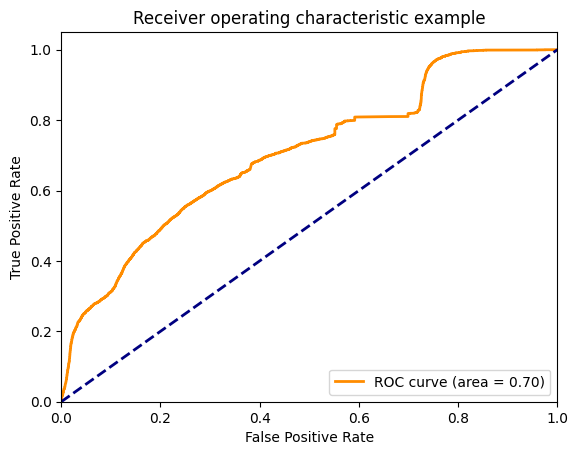

In [15]:
logloss_list = []
for (ii, pp, yy, aa) in indexed_preds:
    ll = -math.log(pp[yy-1]+1e-10)
    logloss_list.append(ll)

fpr, tpr, thresholds = roc_curve(np.asarray(seq_attack),logloss_list, pos_label="Attack")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

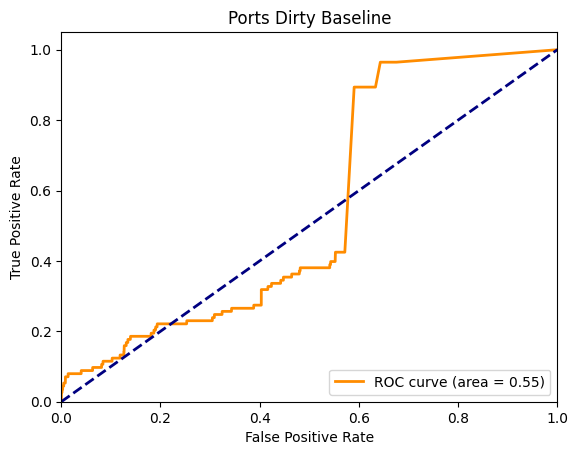

In [16]:
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.items():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ports Dirty Baseline')
plt.legend(loc="lower right")
#plt.savefig("graphics/ports_dirty_ipdyadhour-wise.pdf", format="pdf")
plt.show()